In [2]:
import torch.nn as nn
from torch.functional import F
import torch
from diffusion.Model import *
from torch.nn import init
import numpy as np


# Lista de afazeres 
* Funções de difusão funcionais
* Arquiteturas da rede Funcionais
    * Unet 
    * Unet ++
    * Unet +++
    * Bloco de rede dinamica para testes de desempenho
    * Arquitetura com metodo de treino dinamico
    * treinar sem classificador
    * Gerar duas arquiteturas 
        * Unet de geração de imagem com redes dinamicas
        * Unet de realce de imagem com redes estaticas
* Codigo de carregamento de parametros
* Codigo de treinamento
* Codigo de calculo das loss functions 
* Codigo de calculo das metricas
* Subir no wandb 
* Fazer script de combnacao de datasets

* treino da nova arquitetura de difusão no cluster com dados paralelilzados
* estudar sobre o Sampler para diffusao, Time embedding, Residual Layer, Transformer layers, Convolutioinal layeres necessarias
    * Posso fazer tres versoes com quantidades diferentes de camadas de layers
    * como a rede cospe uma imagem posso usar funcoes prontas para controlar o treinamento e plocar os resultados diretamente(minhas principais duvidas)
    * Outra duvida minha e como usar o no classifier guidance com as camadas dinamicas, terei de ser criativo pois esse passo persiste na inferencia

### Models for image generation with diffusion

## Unet

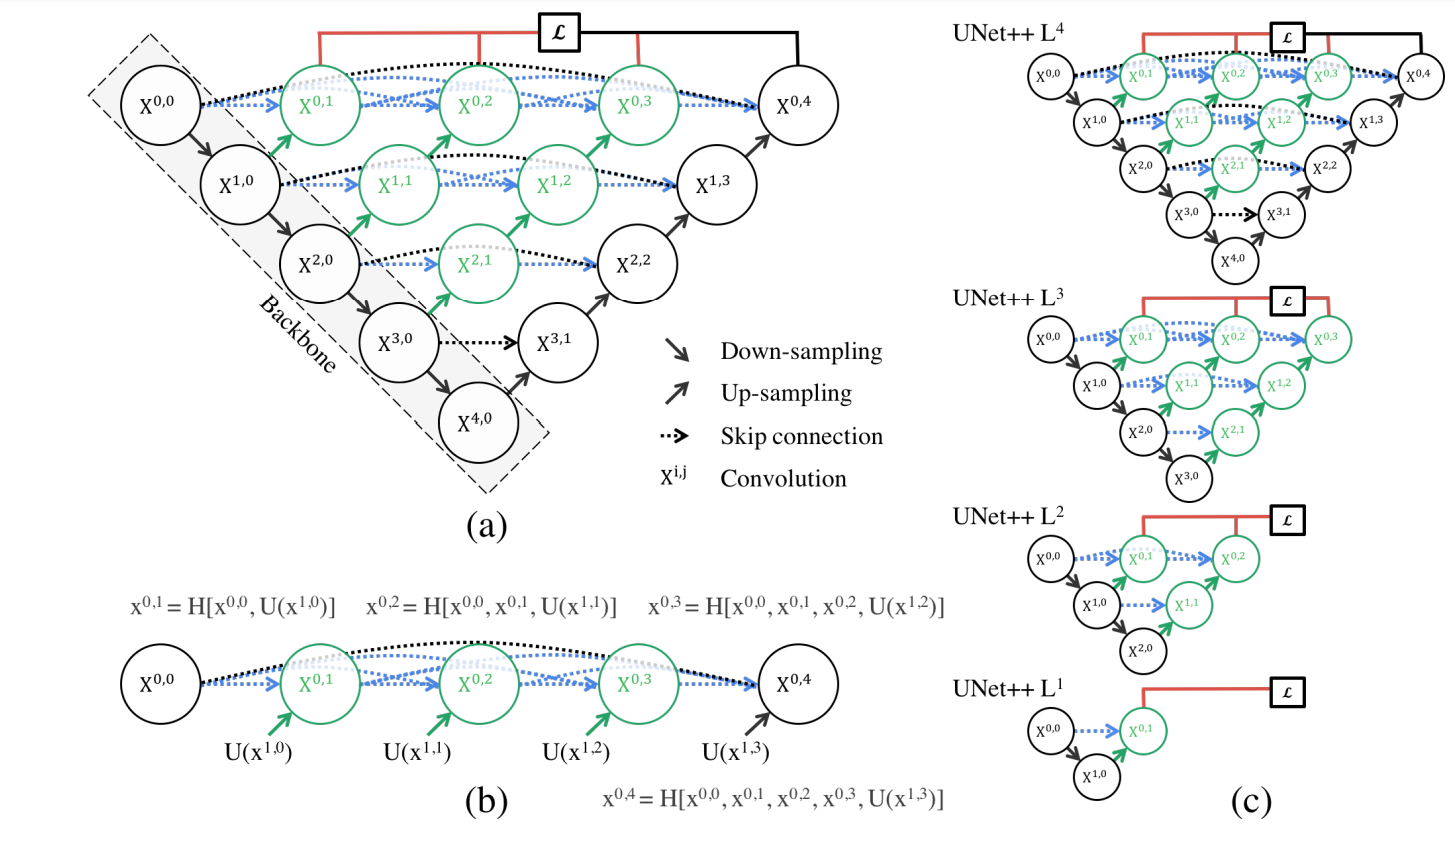

Observações: Usar a inicialização de tensores init xavier. 

## UNET++


### Time Embedding

Os cálculos realizados antes da criação do embedding de tempo podem ser representados pela seguinte equação:

$  \text{emb}_{ij} = \begin{cases} 
\sin\left(\frac{i}{10000^{\frac{2j}{d_{\text{model}}}}}\right) & \text{se } j \text{ é par} \\
\cos\left(\frac{i}{10000^{\frac{2(j-1)}{d_{\text{model}}}}}\right) & \text{se } j \text{ é ímpar}
\end{cases}  $

onde:
- \( i \) varia de 0 a \( $T-1$ \) (número de passos de tempo)
- \( j \) varia de 0 a \( $d_{\text{model}}-1$ \) (dimensão do modelo)
- \( $d_{\text{model}}$ \) é a dimensão do modelo
- \( T \) é o número de passos de tempo

Esta equação descreve como os valores de seno e cosseno são calculados para cada posição \( i \) e dimensão \( j \) do embedding.

In [3]:
class AttnBlock(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.group_norm = nn.GroupNorm(num_groups=min(32, in_ch), num_channels=in_ch)
        self.proj_q = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj_k = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj_v = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.initialize()

    def initialize(self):
        for module in [self.proj_q, self.proj_k, self.proj_v, self.proj]:
            init.xavier_uniform_(module.weight)
            init.zeros_(module.bias)
        init.xavier_uniform_(self.proj.weight, gain=1e-5)

    def forward(self, x):
        B, C, H, W = x.shape

        # Normalização
        h = self.group_norm(x)

        # Projeções Q, K, V
        q = self.proj_q(h)
        k = self.proj_k(h)
        v = self.proj_v(h)

        # Ajusta formato para multiplicação matricial
        q = q.permute(0, 2, 3, 1).view(B, H * W, C)  # (B, H*W, C)
        k = k.view(B, C, H * W)  # (B, C, H*W)
        w = torch.bmm(q, k) * (C ** -0.5)  # (B, H*W, H*W)
        w = F.softmax(w, dim=-1)

        v = v.permute(0, 2, 3, 1).view(B, H * W, C)  # (B, H*W, C)
        h = torch.bmm(w, v)  # (B, H*W, C)
        h = h.view(B, H, W, C).permute(0, 3, 1, 2)  # Volta para (B, C, H, W)

        # Projeção final e residual
        h = self.proj(h)

        return x + h

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class ResBlockUp(nn.Module):
    def __init__(self, in_channels, out_channels, tdim, dropout, attn=False):
        """
        Bloco residual especial para o upsampling que garante o ajuste correto dos canais.
        """
        super(ResBlockUp, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.tdim = tdim

        # Camada para ajustar canais se necessário
        self.channel_adjust = (
            nn.Conv2d(in_channels, out_channels, kernel_size=1) 
            if in_channels != out_channels else None
        )

        # Camadas de convolução e normalização para o bloco residual
        self.block1 = nn.Sequential(
            #nn.GroupNorm(32, out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        )
        self.block2 = nn.Sequential(
            #nn.GroupNorm(32, out_channels),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        )

        # Projeção do time embedding (t)
        self.time_proj = nn.Sequential(
            nn.SiLU(),
            nn.Linear(tdim, out_channels)
        )

        # Atenção opcional
        self.attn = nn.MultiheadAttention(out_channels, num_heads=8) if attn else nn.Identity()

    def forward(self, x, temb):
        # Ajustar canais se necessário
        h = x
        if self.channel_adjust:
            x = self.channel_adjust(x)

        # Aplicar o primeiro bloco convolucional
        h = self.block1(h)

        # Adicionar time embedding ao tensor
        temb_out = self.time_proj(temb).view(temb.size(0), -1, 1, 1)
        h = h + temb_out

        # Aplicar o segundo bloco convolucional
        h = self.block2(h)

        # Aplicar atenção, se habilitada
        if self.attn:
            h = self.attn(h)

        # Soma residual
        return h + x

class _ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, tdim, dropout, attn, num_groups=None):
        super().__init__()
        self.tdim=tdim
        self.out_ch = out_ch
        # Ajusta num_groups dinamicamente mudei de 32 para 64
        
        # Ajustar dinamicamente o número de grupos para ser um divisor de in_ch e out_ch
        if num_groups is None or in_ch % num_groups != 0 or out_ch % num_groups != 0:
            num_groups = min(32, min(in_ch, out_ch))  # Escolhe o menor divisor adequado # Ajusta dinamicamente o num_groups

        assert in_ch % num_groups == 0, f"in_ch ({in_ch}) deve ser divisível por num_groups ({num_groups})"
        assert out_ch % num_groups == 0, f"out_ch ({out_ch}) deve ser divisível por num_groups ({num_groups})"

        self.block1 = nn.Sequential(
            nn.GroupNorm(num_groups, in_ch),
            Swish(),
            nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1),
        )
        self.block2 = nn.Sequential(
            nn.GroupNorm(num_groups, out_ch),
            Swish(),
            nn.Dropout(dropout),
            nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1),
        )
        #####

        self.temb_proj = nn.Sequential(
            Swish(),
            nn.Linear(tdim, out_ch),
        )
        
        self.shortcut = (
            nn.Conv2d(in_ch, out_ch, 1, stride=1, padding=0)
            if in_ch != out_ch
            else nn.Identity()
        )
        self.attn = nn.MultiheadAttention(out_ch, num_heads=8) if attn else nn.Identity()
        
        #self.attn = AttnBlock(out_ch) if attn else nn.Identity()

        self.initialize()

    def initialize(self):
        for module in self.modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                init.xavier_uniform_(module.weight)
                init.zeros_(module.bias)
        init.xavier_uniform_(self.block2[-1].weight, gain=1e-5)

    def forward(self, x, temb):    
        if x.device != temb.device:
                raise ValueError("Input and time embedding must be on the same device.")
        #print(f"[ResBlock] Input shape: {x.shape}, temb {temb.shape} tdim {self.tdim}, out_ch {self.out_ch}")
        h = self.block1(x)
        #print(f"[ResBlock] After block1: {h.shape}, temb {temb.shape} tdim {self.tdim}, out_ch {self.out_ch}/n")
        
        # Ajustar o formato de temb antes da projeção
        temb = temb.view(temb.size(0), -1)  # Garantir forma [batch_size, tdim]
        temb_proj = self.temb_proj(temb)  # Aplicar projeção linear
        #print(f"[ResBlock] After block1: {h.shape}, temb {temb.shape} tdim {self.tdim}, out_ch {self.out_ch}/n")

        temb_proj = temb_proj[:, :, None, None]  # Expansão para [batch_size, out_ch, 1, 1]
        h = self.block2(h)
        #print(f"[ResBlock] Output shape: {h.shape}")
        h = h + self.shortcut(x)
    
        #print(f"[ResBlock] Output shape: {h.shape}")

        # Bloco de atenção, se configurado
        if isinstance(self.attn, nn.MultiheadAttention):  # Apenas aplica atenção se for MultiheadAttention
            
            # Ajusta para formato 3D (seq_len, batch_size, embed_dim)
            batch, channels, height, width = h.shape
            h_reshaped = h.view(batch, channels, -1).permute(2, 0, 1)  # (seq_len, batch, channels)

            # Aplica atenção
            h_attn, _ = self.attn(h_reshaped, h_reshaped, h_reshaped)

            # Volta para formato 4D (batch_size, channels, height, width)
            h = h_attn.permute(1, 2, 0).view(batch, channels, height, width)
            #h =  h + self.res_conv(x)
        else: 
            h = self.attn(h)
        return h




In [4]:
# class UNetPlusPlus(nn.Module):
#     def __init__(self, T, ch, ch_mult, attn, num_res_blocks, dropout):
#         super(UNetPlusPlus, self).__init__()
#         self.T = T
#         self.ch = ch
#         self.ch_mult = ch_mult
#         self.attn = attn
#         self.num_res_blocks = num_res_blocks
#         self.dropout = dropout
#         assert all([i < len(ch_mult) for i in attn]), "Índice de atenção fora do limite."

#         # Time embedding
#         tdim = ch * 4
#         self.time_embedding = TimeEmbedding(T, ch, tdim)

#         # Head (entrada inicial)
#         self.head = nn.Conv2d(3, ch, kernel_size=3, stride=1, padding=1)

#         # Downsampling e upsampling
#         self.downblocks, chs_down = self._make_downblocks(ch, ch_mult, attn, num_res_blocks, dropout, tdim)
#         self.upblocks = self._make_upblocks(ch, ch_mult, attn, num_res_blocks, dropout, chs_down.copy(), tdim)

#         # Middle blocks (gargalo)
#         self.middle_blocks = nn.ModuleList([
#             ResBlock(ch * ch_mult[-1], ch * ch_mult[-1], tdim, dropout, attn=False)
#         ])
#         # Tail (saída final)
#         self.tail = nn.Conv2d(ch, 3, kernel_size=3, stride=1, padding=1)


#     def _make_downblocks(self, ch, ch_mult, attn, num_res_blocks, dropout, tdim):
#         """
#         Cria os blocos de downsampling, cada um composto de várias camadas ResBlock e uma conexão residual.
#         """
#         downblocks = nn.ModuleList()
#         chs_down = []
#         now_ch = ch

#         for i, mult in enumerate(ch_mult):
#             out_ch = ch * mult
#             print(out_ch)
#             chs_down.append(now_ch)  # Salva os canais antes do downsampling
#             res_blocks = nn.ModuleList([
#                 ResBlock(now_ch if j == 0 else out_ch, out_ch, tdim=tdim, dropout=dropout, attn=(i in attn))
#                 for j in range(num_res_blocks)
#             ])
#             downblocks.append(res_blocks)
#             now_ch = out_ch

#         return downblocks, chs_down
#     def _make_upblocks(self, ch, ch_mult, attn, num_res_blocks, dropout, chs_down, tdim):
#         upblocks = nn.ModuleList()
#         now_ch = ch * ch_mult[-1]  # Começa com o número de canais do último bloco de downsampling

#         for i, mult in reversed(list(enumerate(ch_mult))):
#             skip_ch = chs_down.pop()  # Canais da "skip connection" do downsampling
#             out_ch = ch * mult  # Canais do bloco atual
#             in_ch = now_ch + skip_ch  # Combinação dos canais atuais e da "skip connection"

#             # Certifique-se de ajustar os canais para evitar incompatibilidade
#             res_blocks = nn.ModuleList([
#                 ResBlockUp(in_ch if j == 0 else out_ch, out_ch, tdim=tdim, dropout=dropout, attn=(i in attn))
#                 for j in range(num_res_blocks)
#             ])
#             upblocks.append(res_blocks)

#             now_ch = out_ch  # Atualiza o número de canais atuais

#         return upblocks
#     # def _make_upblocks(self, ch, ch_mult, attn, num_res_blocks, dropout, chs_down, tdim):
#     #     upblocks = nn.ModuleList()
#     #     now_ch = ch * ch_mult[-1]  # Começa com o número de canais do último bloco de downsampling

#     #     for i, mult in reversed(list(enumerate(ch_mult))):
#     #         skip_ch = chs_down.pop()  # Canais da "skip connection" do downsampling
#     #         out_ch = ch * mult  # Canais do bloco atual
#     #         in_ch = now_ch + skip_ch  # Combinação dos canais atuais e da "skip connection"

#     #         # Certifique-se de ajustar os canais para evitar incompatibilidade
#     #         res_blocks = nn.ModuleList([
#     #             ResBlock(in_ch if j == 0 else out_ch, out_ch, tdim=tdim, dropout=dropout, attn=(i in attn))
#     #             for j in range(num_res_blocks)
#     #         ])
#     #         upblocks.append(res_blocks)

#     #         now_ch = out_ch  # Atualiza o número de canais atuais

#     #     return upblocks

#     # def forward(self, x, t):
#     #     print(f"[UNetPlusPlus] Input shape: {x.shape}")
#     #     t = self.time_embedding(t)  # Projeta o timestep

#     #     # Head
#     #     h = self.head(x)
#     #     print(f"[UNetPlusPlus] After head: {h.shape}")

#     #     # Downsampling
#     #     skip_connections = []
#     #     for i, res_blocks in enumerate(self.downblocks):
#     #         for res_block in res_blocks:
#     #             h = res_block(h, t)
#     #         skip_connections.append(h)  # Salva a saída para "skip connection"
#     #         h = F.avg_pool2d(h, kernel_size=2)  # Downsample
#     #         print(f"[UNetPlusPlus] After downsampling stage {i}: {h.shape}")

#     #     # Middle Blocks
#     #     for block in self.middle_blocks:
#     #         h = block(h, t)
#     #         print(f"[UNetPlusPlus] After middle block: {h.shape}")

#     #    # Upsampling
#     #     for i, res_blocks in enumerate(self.upblocks):
#     #         h = F.interpolate(h, scale_factor=2, mode="nearest")  # Upsample
#     #         skip = skip_connections.pop()
            
#     #         # Ajuste das dimensões espaciais antes da concatenação
#     #         if h.shape[2:] != skip.shape[2:]:
#     #             diff_h = h.shape[2] - skip.shape[2]
#     #             diff_w = h.shape[3] - skip.shape[3]
#     #             skip = F.pad(skip, (diff_w // 2, diff_w - diff_w // 2, diff_h // 2, diff_h - diff_h // 2))
#     #         print(f"[UNetPlusPlus] Upsampled shape: {h.shape}, skip shape: {skip.shape}")
#     #         # Ajustar o número de canais para corresponder antes da concatenação
#     #         if h.shape[1] != skip.shape[1]:
#     #             skip = nn.Conv2d(skip.shape[1], x.shape[1], kernel_size=1)(skip)

#     #         h = torch.cat([h, skip], dim=1)  # Concat skip connections
#     #         print(f"[UNetPlusPlus] After concat: {h.shape}, t.shape: {t.shape}")
#     #         for res_block in res_blocks:
#     #             h = res_block(h, t)
#     #         print(f"[UNetPlusPlus] After upsampling stage {i}: {h.shape}")


#     #     # Tail
#     #     h = self.tail(h)
#     #     print(f"[UNetPlusPlus] Output shape: {h.shape}")

#     #     return h
#     def forward(self, x, t):
#         print(f"[UNetPlusPlus] Input shape: {x.shape}")
#         t = self.time_embedding(t)  # Projeta o timestep

#         # Head
#         h = self.head(x)
#         print(f"[UNetPlusPlus] After head: {h.shape}")

#         # Downsampling
#         skip_connections = []
#         for i, res_blocks in enumerate(self.downblocks):
#             for res_block in res_blocks:
#                 h = res_block(h, t)
#             skip_connections.append(h)  # Salva a saída para "skip connection"
#             h = F.avg_pool2d(h, kernel_size=2)  # Downsample
#             print(f"[UNetPlusPlus] After downsampling stage {i}: {h.shape}")

#         # Middle Blocks
#         for block in self.middle_blocks:
#             h = block(h, t)
#             print(f"[UNetPlusPlus] After middle block: {h.shape}")

#         # Upsampling
#         for i, res_blocks in enumerate(self.upblocks):
#             h = F.interpolate(h, scale_factor=2, mode="nearest")  # Upsample
#             skip = skip_connections.pop()
            
#             # Ajuste das dimensões espaciais antes da concatenação
#             if h.shape[2:] != skip.shape[2:]:
#                 diff_h = h.shape[2] - skip.shape[2]
#                 diff_w = h.shape[3] - skip.shape[3]
#                 skip = F.pad(skip, (diff_w // 2, diff_w - diff_w // 2, diff_h // 2, diff_h - diff_h // 2))
#             print(f"[UNetPlusPlus] Upsampled shape: {h.shape}, skip shape: {skip.shape}")
            
#             # Ajustar o número de canais da skip connection para corresponder ao input do resblock
#             if h.shape[1] != skip.shape[1]:
#                 skip = nn.Conv2d(skip.shape[1], h.shape[1], kernel_size=1).to(h.device)(skip)

#             h = torch.cat([h, skip], dim=1)  # Concat skip connections
#             print(f"[UNetPlusPlus] After concat: {h.shape}, t.shape: {t.shape}")
#             for res_block in res_blocks:
#                 h = res_block(h, t)
#             print(f"[UNetPlusPlus] After upsampling stage {i}: {h.shape}")

#         # Tail
#         h = self.tail(h)
#         print(f"[UNetPlusPlus] Output shape: {h.shape}")

#         return h



In [5]:
# T = 1000
# ch = 64
# ch_mult = [1, 2, 2, 2]
# attn = [1, 2]  # Índices dos níveis com atenção
# num_res_blocks = 2
# dropout = 0.1

# model = UNetPlusPlus(T, ch, ch_mult, attn, num_res_blocks, dropout)

# x = torch.randn(1, 3, 256, 256)  # Exemplo de entrada
# t = torch.randint(0, T, (1,))  # Exemplo de timestep
# output = model(x, t)  # Forward pass
# print(f"Output shape: {output.shape}")

## Unet Dynamica

In [6]:
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, tdim, dropout, attn=True):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.GroupNorm(32, in_ch),
            Swish(),
            nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1),
        )
        self.temb_proj = nn.Sequential(
            Swish(),
            nn.Linear(tdim, out_ch),
        )
        self.cond_proj = nn.Sequential(
            Swish(),
            nn.Linear(tdim, out_ch),
        )
        self.block2 = nn.Sequential(
            nn.GroupNorm(32, out_ch),
            Swish(),
            nn.Dropout(dropout),
            nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1),
        )

        self.attn = nn.MultiheadAttention(out_ch, num_heads=8) if attn else nn.Identity()

        if in_ch != out_ch:
            self.shortcut = nn.Conv2d(in_ch, out_ch, 1, stride=1, padding=0)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x, temb, cemb=None):
        h = self.block1(x)
        h += self.temb_proj(temb)[:, :, None, None]
        if cemb is not None:
            h += self.cond_proj(cemb)[:, :, None, None]
        h = self.block2(h)
        h = h + self.shortcut(x)
        
        if isinstance(self.attn, nn.MultiheadAttention):
            batch, channels, height, width = h.shape
            h_reshaped = h.view(batch, channels, -1).permute(2, 0, 1)  # (seq_len, batch, channels)
            h_attn, _ = self.attn(h_reshaped, h_reshaped, h_reshaped)
            h = h_attn.permute(1, 2, 0).view(batch, channels, height, width)
        else:
            h = self.attn(h)
        return h
    
    
    # def forward(self, x, temb, labels):
    #     h = self.block1(x)
    #     h += self.temb_proj(temb)[:, :, None, None]
    #     h += self.cond_proj(labels)[:, :, None, None]
    #     h = self.block2(h)

    #     h = h + self.shortcut(x)
    #     # Bloco de atenção, se configurado
    #     if isinstance(self.attn, nn.MultiheadAttention):  # Apenas aplica atenção se for MultiheadAttention
            
    #         # Ajusta para formato 3D (seq_len, batch_size, embed_dim)
    #         batch, channels, height, width = h.shape
    #         h_reshaped = h.view(batch, channels, -1).permute(2, 0, 1)  # (seq_len, batch, channels)

    #         # Aplica atenção
    #         h_attn, _ = self.attn(h_reshaped, h_reshaped, h_reshaped)

    #         # Volta para formato 4D (batch_size, channels, height, width)
    #         h = h_attn.permute(1, 2, 0).view(batch, channels, height, width)
    #         #h =  h + self.res_conv(x)
    #     else: 
    #         h = self.attn(h)
    #     return h

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from DiffusionFreeGuidence import TimeEmbedding, ConditionalEmbedding, DownSample, UpSample, Swish

class DynamicUNet_0(nn.Module):
    def __init__(self, T, num_labels, ch, ch_mult, num_res_blocks, dropout, attn):
        super().__init__()
        self.attn = attn
        tdim = ch * 4
        self.time_embedding = TimeEmbedding(T, ch, tdim)
        self.cond_embedding = ConditionalEmbedding(num_labels, ch, tdim)

        ## Layers 
        self.head = nn.Conv2d(3, ch, kernel_size=3, stride=1, padding=1)
        self.downblocks, self.chs, self.now_ch = self.create_downblocks(ch, ch_mult, num_res_blocks, tdim, dropout)
        self.middleblocks = self.create_middleblocks(self.now_ch, tdim, dropout)
        self.upblocks = self.create_upblocks(ch, ch_mult, num_res_blocks, tdim, dropout)
        
        self.tail = nn.Sequential(
            nn.GroupNorm(32, 128),
            Swish(),
            nn.Conv2d(self.now_ch, 3, 3, stride=1, padding=1)
        )
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.head.weight)
        init.zeros_(self.head.bias)
        init.xavier_uniform_(self.tail[-1].weight, gain=1e-5)
        init.zeros_(self.tail[-1].bias)


    def create_downblocks(self, ch, ch_mult, num_res_blocks, tdim, dropout):
        downblocks = nn.ModuleList()
        chs = [ch]
        now_ch = ch

        for i, mult in enumerate(ch_mult):
            out_ch = ch * mult
            for _ in range(num_res_blocks):
                downblocks.append(ResBlock(in_ch=now_ch, out_ch=out_ch, tdim=tdim, dropout=dropout,attn=False))
                now_ch = out_ch
                chs.append(now_ch)
            if i != len(ch_mult) - 1:
                downblocks.append(DownSample(now_ch))
                chs.append(now_ch)
        print("now channel", chs)
        return downblocks, chs, now_ch

    def create_middleblocks(self, now_ch, tdim, dropout):
        return nn.ModuleList([
            ResBlock(now_ch, now_ch, tdim, dropout, attn=True),# Subaquatic
            ResBlock(now_ch, now_ch, tdim, dropout, attn=False), # Atmospheric
            ResBlock(now_ch, now_ch, tdim, dropout, attn=True),# Subaquatic
            ResBlock(now_ch, now_ch, tdim, dropout, attn=False),# Atmospheric
        ])

    def create_upblocks(self, ch, ch_mult, num_res_blocks, tdim, dropout):
        upblocks = nn.ModuleList()
        chs = self.chs.copy()
        now_ch = self.now_ch

        for i, mult in reversed(list(enumerate(ch_mult))):
            out_ch = ch * mult
            for _ in range(num_res_blocks + 1):
                upblocks.append(ResBlock(in_ch=chs.pop() + now_ch, out_ch=out_ch, tdim=tdim, dropout=dropout, attn=False))
                now_ch = out_ch
            if i != 0:
                upblocks.append(UpSample(now_ch))
        print('Now_ch', chs)
        assert len(chs) == 0
        return upblocks

    def dynamic_forward(self, x, t, labels):
        """
        Dynamic forward pass based on input image type.
        x: input image tensor
        t: timestep embedding tensor
        labels: conditional labels tensor
        """
        # Determine image type using statistical thresholding on color channels
        red_channel_mean = x[:, 0, :, :].mean()  # Mean of red channel
        blue_channel_mean = x[:, 2, :, :].mean()  # Mean of blue channel

        # Activate subaquatic layers if red < blue; otherwise, activate atmospheric layers
        is_subaquatic = blue_channel_mean > red_channel_mean

        for i, layer in enumerate(self.middleblocks):
            if is_subaquatic:
                if i % 2 == 0:  # Enable subaquatic layers (even-indexed)
                    for param in layer.parameters():
                        param.requires_grad = True
                else:  # Freeze atmospheric layers (odd-indexed)
                    for param in layer.parameters():
                        param.requires_grad = False
            else:
                if i % 2 != 0:  # Enable atmospheric layers (odd-indexed)
                    for param in layer.parameters():
                        param.requires_grad = True
                else:  # Freeze subaquatic layers (even-indexed)
                    for param in layer.parameters():
                        param.requires_grad = False
    def forward(self, x, t, labels):
        # Ajuste dinâmico dos middleblocks com base no tipo de entrada
        self.dynamic_forward(x, t, labels)

        # Timestep embedding
        temb = self.time_embedding(t)
        cemb = self.cond_embedding(labels)
        
        # Downsampling
        h = self.head(x)
        hs = [h]
        for layer in self.downblocks:
            h = layer(h, temb, cemb)  # Passando os argumentos corretos
            hs.append(h)

        # Middle
        for layer in self.middleblocks:
            h = layer(h, temb, cemb)  # Passando os argumentos corretos

        # Upsampling
        for layer in self.upblocks:
            if isinstance(layer, ResBlock):
                h = torch.cat([h, hs.pop()], dim=1)
            h = layer(h, temb, cemb)  # Passando os argumentos corretos
        
        print(f"Input tail Block{h.shape}")

        h = self.tail(h)
        assert len(hs) == 0
        return h



In [9]:
import torch
import torch.nn as nn
import torch.nn.init as init
from DiffusionFreeGuidence import TimeEmbedding, ConditionalEmbedding, DownSample, UpSample, Swish, ResBlock


class DynamicUNet(nn.Module):
    def __init__(self, T, num_labels, ch, ch_mult, num_res_blocks, dropout, attn):
        super().__init__()
        self.attn = attn
        tdim = ch * 4
        self.time_embedding = TimeEmbedding(T, ch, tdim)
        self.cond_embedding = ConditionalEmbedding(num_labels, ch, tdim)

        ## Layers
        self.head = nn.Conv2d(3, ch, kernel_size=3, stride=1, padding=1)
        self.downblocks, self.chs, self.now_ch = self.create_downblocks(ch, ch_mult, num_res_blocks, tdim, dropout)
        self.middleblocks = self.create_middleblocks(self.now_ch, tdim, dropout)
        self.upblocks = self.create_upblocks(ch, ch_mult, num_res_blocks, tdim, dropout)

        self.tail = nn.Sequential(
            nn.GroupNorm(32, ch),
            Swish(),
            nn.Conv2d(ch, 3, kernel_size=3, stride=1, padding=1)
        )
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.head.weight)
        init.zeros_(self.head.bias)
        init.xavier_uniform_(self.tail[-1].weight, gain=1e-5)
        init.zeros_(self.tail[-1].bias)

    def create_downblocks(self, ch, ch_mult, num_res_blocks, tdim, dropout):
        downblocks = nn.ModuleList()
        chs = [ch]
        now_ch = ch

        for i, mult in enumerate(ch_mult):
            out_ch = ch * mult
            for _ in range(num_res_blocks):
                downblocks.append(ResBlock(in_ch=now_ch, out_ch=out_ch, tdim=tdim, dropout=dropout, attn=self.attn))
                now_ch = out_ch
                chs.append(now_ch)
            if i != len(ch_mult) - 1:
                downblocks.append(DownSample(now_ch))
                chs.append(now_ch)
        return downblocks, chs, now_ch

    def create_middleblocks(self, now_ch, tdim, dropout):
        return nn.ModuleList([
            ResBlock(now_ch, now_ch, tdim, dropout, attn=True),
            ResBlock(now_ch, now_ch, tdim, dropout, attn=False)
        ])

    def create_upblocks(self, ch, ch_mult, num_res_blocks, tdim, dropout):
        upblocks = nn.ModuleList()
        chs = self.chs.copy()
        now_ch = self.now_ch

        for i, mult in reversed(list(enumerate(ch_mult))):
            out_ch = ch * mult
            for _ in range(num_res_blocks):
                upblocks.append(ResBlock(in_ch=chs.pop() + now_ch, out_ch=out_ch, tdim=tdim, dropout=dropout, attn=self.attn))
                now_ch = out_ch
            if i != 0:
                upblocks.append(UpSample(now_ch))
        return upblocks

    def forward(self, x, t, labels):
        temb = self.time_embedding(t)
        cemb = self.cond_embedding(labels)

        # Downsampling
        h = self.head(x)
        hs = [h]  # Armazena saída inicial
        for layer in self.downblocks:
            h = layer(h, temb, cemb)
            hs.append(h)  # Salva a saída de cada camada

        # Middle
        for layer in self.middleblocks:
            h = layer(h, temb, cemb)

        # Upsampling
        for layer in self.upblocks:
            if isinstance(layer, ResBlock):
                # Garante que sempre existe um tensor para concatenar
                assert len(hs) > 0, "A lista `hs` está vazia antes do esperado."

                # Remove o último tensor de `hs` e ajusta o tamanho, se necessário
                skip_h = hs.pop()
                if h.shape[2:] != skip_h.shape[2:]:
                    skip_h = F.interpolate(skip_h, size=h.shape[2:], mode="nearest")

                h = torch.cat([h, skip_h], dim=1)
            h = layer(h, temb, cemb)

        # # Garantia final
        # print(f"Elementos restantes em hs: {len(hs)}")
        # assert len(hs) == 0, f"A lista `hs` contém {len(hs)} elementos restantes no final do Upsampling."

        return self.tail(h)

# Teste do modelo
if __name__ == "__main__":
    T = 1000
    num_labels = 10
    ch = 128
    ch_mult = [1, 2, 2, 2]
    num_res_blocks = 2
    dropout = 0.1
    attn = False

    model = DynamicUNet(T, num_labels, ch, ch_mult, num_res_blocks, dropout, attn)#.to("cuda")

    batch_size = 1
    image_size = 256
    x = torch.randn(batch_size, 3, image_size, image_size)#.to("cuda")  # Imagens de entrada
    t = torch.randint(0, T, size=(batch_size,))#.to("cuda")  # Timestep aleatório
    labels = torch.randint(0, num_labels, size=(batch_size,))#.to("cuda")  # Rótulos aleatórios

    y = model(x, t, labels)  # Passagem no modelo
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {y.shape}")


Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 3, 256, 256])


## ```Difussers hugging face``` Teste de funções modulares para modelos de difusão

link: [Diffusers](https://huggingface.co/docs/diffusers/stable_diffusion)

Testar:
* Scheduller[Feito]
* Noise [Feito]
* Prediction [Em andamento]
* No Classifier Guidance 
    * Ajustar com os Datasets
* Treino
    * Uso dos datasets 
* Teste
* Validação
    *  MEtricas
* Models 
    * Unet Dynamica
    * Unet normal
    * Unet ++
    * Unet +++



# Difusao


In [ ]:
import sys
import os

# Adiciona o diretório pai ao sys.path
from Loss.loss import *
from typing import Dict
from tensorboardX import SummaryWriter
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from kornia.losses import ssim_loss
import numpy as np
import lpips


def extract(v, t, x_shape):
    """
    Extract some coefficients at specified timesteps, then reshape to
    [batch_size, 1, 1, 1, 1, ...] for broadcasting purposes.
    """
    device = t.device
    out = torch.gather(v, index=t, dim=0).float().to(device)
    return out.view([t.shape[0]] + [1] * (len(x_shape) - 1))


class GaussianDiffusionTrainer(nn.Module):
    def __init__(self, model, beta_1, beta_T, T, Pre_train=None, perceptual='vgg'):
        super().__init__()

        self.model = model
        self.T = T

        self.register_buffer(
            'betas', torch.linspace(beta_1, beta_T, T).double())
        alphas = 1. - self.betas
        alphas_bar = torch.cumprod(alphas, dim=0)
        self.register_buffer(
            'sqrt_alphas_bar', torch.sqrt(alphas_bar))
        self.register_buffer(
            'sqrt_one_minus_alphas_bar', torch.sqrt(1. - alphas_bar))
        ### Losses
        self.L_color = None
        self.num = 0
        ### Necessita de avaliacao perceptual
        if perceptual == 'vgg':
            self.loss_perceptual = lpips.LPIPS(net='vgg')
        elif perceptual == 'squeeze':
            self.loss_perceptual = lpips.LPIPS(net='squeeze')
        elif perceptual == 'alex':
            self.loss_perceptual = lpips.LPIPS(net='alex')
        elif self.loss_perceptual == 'DINO':
            self.loss_perceptual = lpips.LPIPS(net='dino')#adicionar dino aq

        self.light_loss = light_loss()
        self.color_loss = color_loss()
        self.L_color = L_color()

    def forward(self, gt_images, lowlight_image, epoch):
        """
        Algorithm 1.
        """
        t = torch.randint(self.T, size=(gt_images.shape[0],), device=gt_images.device)
        noise = torch.randn_like(gt_images)
        y_t = (
                extract(self.sqrt_alphas_bar, t, gt_images.shape) * gt_images +
                extract(self.sqrt_one_minus_alphas_bar, t, gt_images.shape) * noise)

        input = torch.cat([lowlight_image, y_t], dim=1).float()

        noise_pred = self.model(input, t)

        #########################
        ### LOSS ###Ehancement###
        #########################

        loss = 0
        mse_loss = F.mse_loss(noise_pred, noise, reduction='none')
        loss += mse_loss

        y_0_pred = 1 / extract(self.sqrt_alphas_bar, t, gt_images.shape) * (
                    y_t - extract(self.sqrt_one_minus_alphas_bar, t, gt_images.shape) * noise_pred).float()

        second_start = 20
        col_loss = 0
        col_loss_weight = 100
        if epoch < second_start:
            col_loss_weight = 0
        col_loss = self.color_loss(y_0_pred, gt_images) * col_loss_weight
        loss += col_loss

        exposure_loss = 0
        exposure_loss_weight = 20
        if epoch < second_start:
            exposure_loss_weight = 0
        exposure_loss = self.light_loss(y_0_pred, gt_images) * exposure_loss_weight
        loss += exposure_loss

        ssimLoss = 0
        ssim_weight = 2.83
        ssimLoss = ssim_loss(y_0_pred, gt_images, window_size=11) * ssim_weight
        loss += ssimLoss

        perceptual_loss = 0
        perceptual_loss_weight = 30
        perceptual_loss = self.loss_perceptual(gt_images, y_0_pred) * perceptual_loss_weight
        loss += perceptual_loss

        #Perceptual Loss


        #Color Loss


        #Generative Loss


        #Exposure Loss


        return [loss, mse_loss, col_loss, exposure_loss, ssimLoss, perceptual_loss]


class GaussianDiffusionSampler(nn.Module):
    def __init__(self, model, beta_1, beta_T, T):
        super().__init__()

        self.model = model
        self.T = T

        self.register_buffer('betas', torch.linspace(beta_1, beta_T, T).double())
        alphas = 1. - self.betas
        alphas_bar = torch.cumprod(alphas, dim=0)
        alphas_bar_prev = F.pad(alphas_bar, [1, 0], value=1)[:T]
        self.sqrt_alphas_bar = alphas_bar
        self.sqrt_one_minus_alphas_bar = torch.sqrt(1. - alphas_bar)
        self.alphas_bar = alphas_bar
        self.one_minus_alphas_bar = (1. - alphas_bar)
        self.register_buffer('coeff1', torch.sqrt(1. / alphas))
        self.register_buffer('coeff2', self.coeff1 * (1. - alphas) / torch.sqrt(1. - alphas_bar))

        self.register_buffer('posterior_var', self.betas * (1. - alphas_bar_prev) / (1. - alphas_bar))

    def predict_xt_prev_mean_from_eps(self, t, eps, y_t):
        assert y_t.shape == eps.shape
        return (
            extract(self.coeff1, t, y_t.shape) * y_t -
            extract(self.coeff2, t, y_t.shape) * eps
        )

    def p_mean_variance(self, input, t, y_t):
        var = torch.cat([self.posterior_var[1:2], self.betas[1:]])
        var = extract(var, t, input.shape)
        eps = self.model(input, t)
        xt_prev_mean = self.predict_xt_prev_mean_from_eps(t, eps, y_t)

        return xt_prev_mean, var

    def forward(self, lowlight_image, ddim=False, unconditional_guidance_scale=1, ddim_step=None):
        if ddim == False:
            device = lowlight_image.device
            noise = torch.randn_like(lowlight_image).to(device)
            y_t = noise
            for time_step in reversed(range(self.T)):
                t = y_t.new_ones([y_t.shape[0], ], dtype=torch.long) * time_step
                input = torch.cat([lowlight_image, y_t], dim=1).float()
                mean, var = self.p_mean_variance(input, t, y_t)
                if time_step > 0:
                    noise = torch.randn_like(y_t)
                else:
                    noise = 0
                y_t = mean + torch.sqrt(var) * noise

            y_0 = y_t
            return torch.clip(y_0, -1, 1)

        else:
            device = lowlight_image.device
            noise = torch.randn_like(lowlight_image).to(device)
            y_t = noise

            step = 1000 / ddim_step
            step = int(step)
            seq = range(0, 1000, step)
            seq_next = [-1] + list(seq[:-1])
            for i, j in zip(reversed(seq), reversed(seq_next)):
                t = (torch.ones(y_t.shape[0]) * i).to(device).long()
                next_t = (torch.ones(y_t.shape[0]) * j).to(device).long()
                at = extract(self.alphas_bar.to(device), (t + 1).long(), y_t.shape)
                at_next = extract(self.alphas_bar.to(device), (next_t + 1).long(), y_t.shape)
                input = torch.cat([lowlight_image, y_t], dim=1).float()
                eps = self.model(input, t)

                # classifier free guide
                if unconditional_guidance_scale != 1:
                    eps_unconditional = self.model(input, t, context_zero=True)
                    eps = eps_unconditional + unconditional_guidance_scale * (eps - eps_unconditional)

                y0_pred = (y_t - eps * (1 - at).sqrt()) / at.sqrt()
                eta = 0
                c1 = eta * ((1 - at / at_next) * (1 - at_next) / (1 - at)).sqrt()
                c2 = ((1 - at_next) - c1 ** 2).sqrt()
                y_t = at_next.sqrt() * y0_pred + c1 * torch.randn_like(lowlight_image) + c2 * eps
            y_0 = y_t
            return torch.clip(y_0, -1, 1)


# Funções de teste
class DummyModel(nn.Module):
    def forward(self, x, t, context_zero=False):
        return x[:, :3, :, :]  # Modelo fictício que retorna a entrada com o tamanho correto


def test_trainer():
    model = DummyModel()  # Modelo de teste
    trainer = GaussianDiffusionTrainer(model, 0.1, 0.2, 1000)
    gt_images = torch.randn(8, 3, 256, 256)
    epoch = 10
    [loss, mse_loss, col_loss, exp_loss, ssim_loss, perceptual_loss] = trainer(gt_images, gt_images, epoch)

    print("Trainer losses:", "Geral",loss.mean().item(), "MSE",mse_loss.mean().item(), "col",col_loss.mean().item(), "Exposure",exp_loss.mean().item(), "SSIM",ssim_loss.mean().item(), "VGG",perceptual_loss.mean().item())


def test_sampler():
    model = DummyModel()  # Modelo de teste
    sampler = GaussianDiffusionSampler(model, 0.1, 0.2, 1000)
    lowlight_image = torch.randn(8, 3, 256, 256)
    generated_image = sampler(lowlight_image)
    print("Generated image shape:", generated_image.shape)


if __name__ == "__main__":
    test_trainer()
    test_sampler()

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/pdi_4/anaconda3/envs/CLEDiff/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pdi_4/anaconda3/envs/CLEDiff/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/pdi_4/anaconda3/envs/CLEDiff/lib/python3.11/site-packages/lpips/weights/v0.1/vgg.pth
Trainer losses: Geral nan MSE 2.003148317337036 col 0.0 Exposure nan SSIM nan VGG 16.66745948791504
Generated image shape: torch.Size([8, 3, 256, 256])


In [ ]:
from utils.utils import *
from torch.utils.data import DataLoader
def train(batch_size, epochs, underwater_data_name, atmospheric_data_name):

    underwater_data, atmospheric_data = Underwater_Dataset(underwater_dataset_name=underwater_data_name), Atmospheric_Dataset(atmospheric_dataset_name=atmospheric_data_name)
    underwater_loader, atmospheric_loader = DataLoader(underwater_data, batch_size=batch_size), DataLoader(atmospheric_data, batch_size=batch_size)
    model = DummyModel()  # Substitua pelo seu modelo real
    trainer = GaussianDiffusionTrainer(model, 0.1, 0.2, 1000)

    # Determine o dataloader maior
    if len(underwater_loader.dataset) > len(atmospheric_loader.dataset):
        main_loader = underwater_loader
        secondary_loader = atmospheric_loader
    else:
        main_loader = atmospheric_loader
        secondary_loader = underwater_loader
    # O uso de embbed nesta parte esta errado, estou indiretamentoe usando embbed para treinar as labels da imagem
    for epoch in range(epochs):  # Número de épocas de treinamento
        for main_batch, secondary_batch in zip(main_loader, secondary_loader):
            gt_images, lowlight_image = main_batch
            secondary_gt_images, secondary_lowlight_image = secondary_batch

            # Treinamento com o dataloader principal
            context_embed = secondary_lowlight_image  # Usando a imagem do dataset secundário como contexto
            losses = trainer(gt_images, lowlight_image, context_embed, epoch)
            print(f"Epoch {epoch}, Main Loader Losses: {losses}")

            # Treinamento com o dataloader secundário
            context_embed = lowlight_image  # Usando a imagem do dataset principal como contexto
            losses = trainer(secondary_gt_images, secondary_lowlight_image, context_embed, epoch)
            print(f"Epoch {epoch}, Secondary Loader Losses: {losses}")
if __name__ == "__main__":
    train(batch_size=8, epochs=1,underwater_data_name="UIEB",atmospheric_data_name="HDR+")

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/pdi_4/anaconda3/envs/CLEDiff/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pdi_4/anaconda3/envs/CLEDiff/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/pdi_4/anaconda3/envs/CLEDiff/lib/python3.11/site-packages/lpips/weights/v0.1/vgg.pth


ValueError: too many values to unpack (expected 2)

# Geração de imagem e aprendizado de caracteristicas
Aprendizado não supervisionado pela rede nos datasets, funções de perda perceptuais e estruturais.


**Posso fazer as duas redes se treinar, salvar o checkpoint, adionar as loss e novos dados e continuar treinando**

# Realce de Imagem 
Novas Funções de perda para realce de cor e detalhes na imagem e dados anotados